In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


In [26]:
#define functions

def process_sample(dir_trail,d='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert all ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    ra_t=[]
    dec_t=[]

    ra_l=[]
    dec_l=[]

    for i in range(len(allfname_trail)):
        ra_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
        dec_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
        
    for ii in range(len(allfname_lead)):
        ra_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
        dec_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
        
    raall_t = np.array([item for sublist in ra_t for item in sublist])
    decall_t = np.array([item for sublist in dec_t for item in sublist])

    raall_l = np.array([item for sublist in ra_l for item in sublist])
    decall_l = np.array([item for sublist in dec_l for item in sublist])
    
    if d=='radec' :
        return (raall_t,decall_t,raall_l,decall_l)
    
    elif d=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(raall_t,decall_t,degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(raall_l,decall_l,degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
    else : 
        print ("acceptable output format : radec or xieta")
        

def compute_ndenxi(xi,minxi=0.25,maxxi=14.35,bw=0.1):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    nden=np.histogram(xi,xibin_edge,density=True)[0]
    Ndn=np.histogram(xi,xibin_edge)[0]
    nsample=numpy.sum(Ndn)
    smooth_xi=np.loadtxt('/home/nil/Dropbox/streamgap-pepper/smooth_Pal5_samples/Pal5_smooth_stream_all_samples_trailing_minxi0.2_maxxi14.4_noSCFbar.dat')[:,0][:nsample]
    Ndnsmooth=np.histogram(smooth_xi,xibin_edge)[0]
    
    nden_norm=[float(Ndn[i])/float(Ndnsmooth[i]) for i in range(len(Ndn))]
    print (nsample , len(smooth_xi))
    #print (Ndn, Ndnsmooth)

    shot_noise=numpy.sqrt(Ndn)

    err=shot_noise/(N*bw)
    
    return (midxi,nden_norm,err)


def compute_ndenxi_polyfit(xi,minxi=0.25,maxxi=14.35,bw=0.1):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    nden=np.histogram(xi,xibin_edge,density=True)[0]
    Ndn=np.histogram(xi,xibin_edge)[0]
    
    shot_noise=numpy.sqrt(Ndn)
    err=shot_noise/(N*bw)
    
    pp= Polynomial.fit(midxi,Ndn,deg=3,w=1/err)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(midxi,Ndn,ls='steps-mid')
    plt.errorbar(midxi,Ndn,err,marker='None',ls='None')
    plt.plot(midxi,pp(np.array(midxi)),c='r')
    
    nden_norm=Ndn/pp(np.array(midxi))
    
    plt.subplot(1,2,2)
    plt.plot(midxi,nden_norm,ls='steps-mid')
    plt.errorbar(midxi,nden_norm,err,marker='None',ls='None')
      
    
    plt.show()
  
    return (midxi,nden_norm,err)
    
    

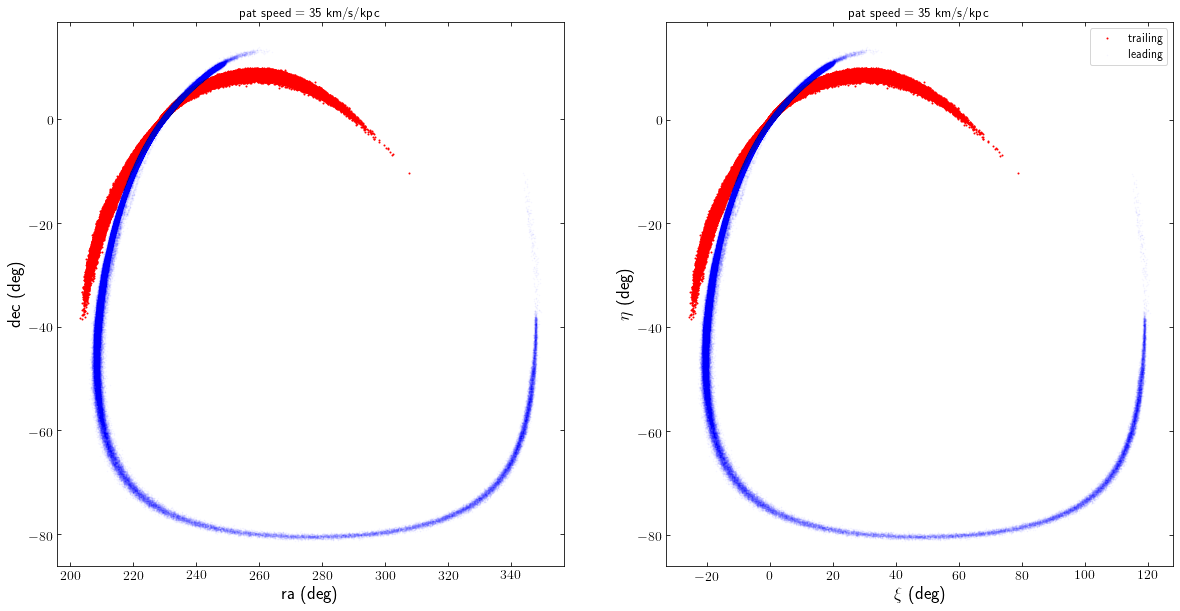

In [38]:
dir35='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/Mbar10_10_barphi27_patspeed35/trailing/'
ra_t, dec_t,ra_l,dec_l=process_sample(dir35,d='radec')
xi_t,eta_t,xi_l,eta_l=process_sample(dir35,d='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t,dec_t,s=1,c='r',label='trailing')
plt.scatter(ra_l,dec_l,s=1,c='b',label='leading',alpha=0.02)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('pat speed = 35 km/s/kpc')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing')
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=0.02)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title('pat speed = 35 km/s/kpc')
plt.legend(loc='upper right')
plt.show()


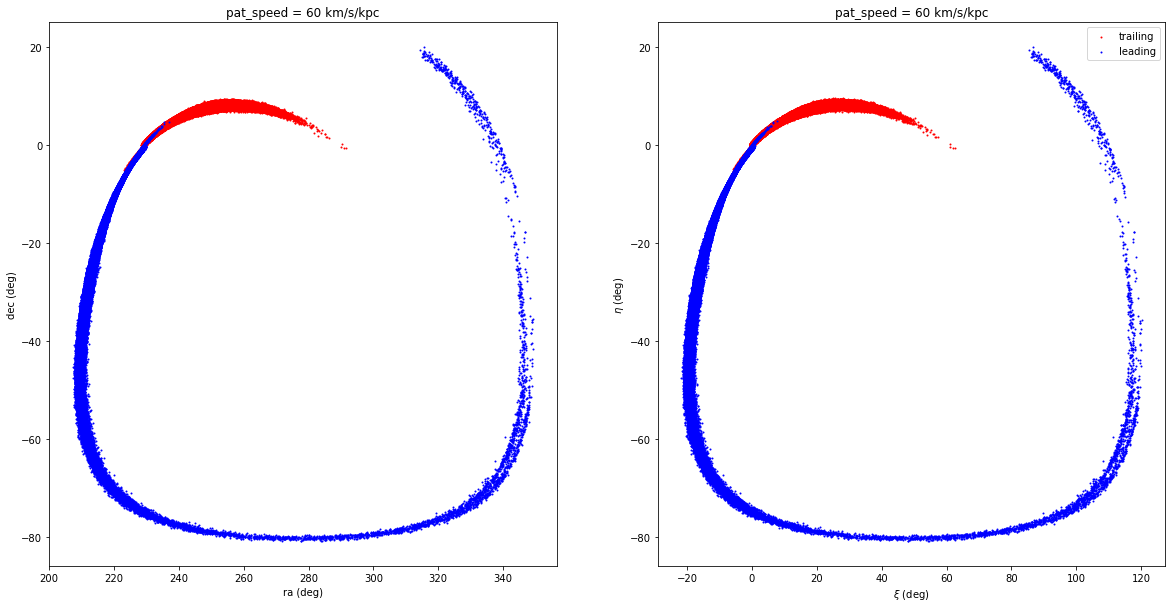

In [5]:
dir60='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/Mbar10_10_barphi27_patspeed60/trailing/'
ra_t1, dec_t1,ra_l1,dec_l1=process_sample(dir60,d='radec')
xi_t1,eta_t1,xi_l1,eta_l1=process_sample(dir60,d='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t1,dec_t1,s=1,c='r',label='trailing')
plt.scatter(ra_l1,dec_l1,s=1,c='b',label='leading')
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('pat_speed = 60 km/s/kpc')

#plot xi, eta
plt.subplot(1,2,2)
plt.scatter(xi_t1,eta_t1,s=1,c='r',label='trailing')
plt.scatter(xi_l1,eta_l1,s=1,c='b',label='leading')
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title('pat_speed = 60 km/s/kpc')
plt.legend(loc='upper right')
plt.show()


997000
no of xi bins = 141
499180 499180
998000
no of xi bins = 141
681151 681151


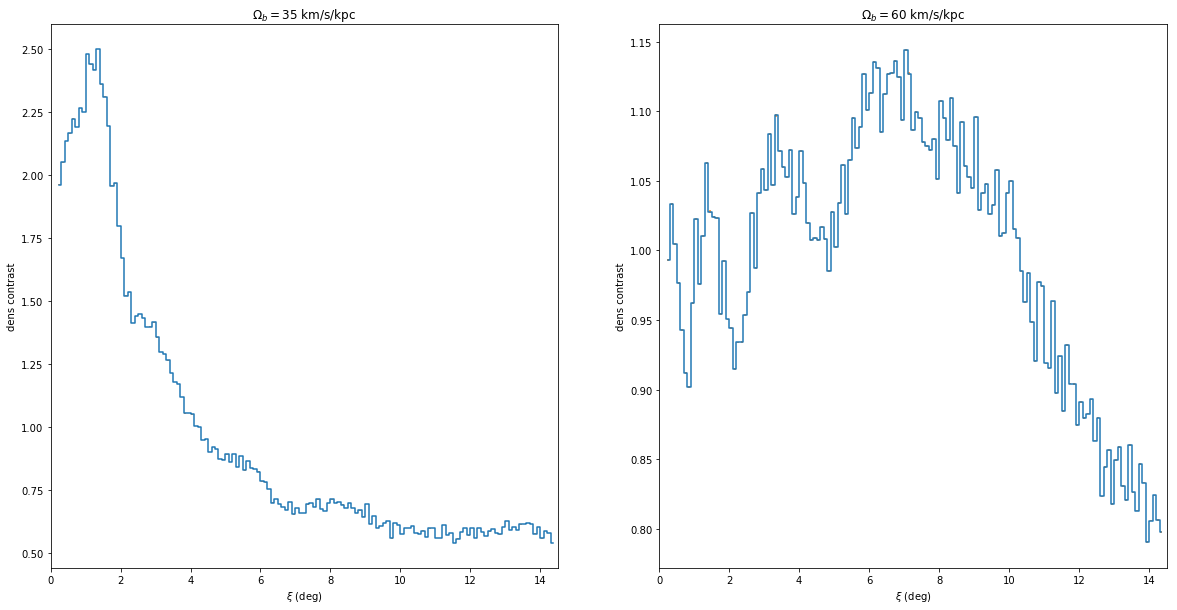

In [11]:
#compute density along xi and save 

midxi,nden,err = compute_ndenxi(xi_t,minxi=0.25,maxxi=14.35,bw=0.1)

midxi1,nden1,err1 = compute_ndenxi(xi_t1,minxi=0.25,maxxi=14.35,bw=0.1)

#print (midxi)

#35 km/s/kpc
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)

plt.plot(midxi,nden,ls='steps-mid')
plt.errorbar(midxi,nden,err,marker='None',ls='None')
plt.title(r'$\Omega_{b} = 35$ km/s/kpc')
plt.xlim(0.,14.5)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel('dens contrast')


#60km/s/kpc
plt.subplot(1,2,2)
plt.plot(midxi1,nden1,ls='steps-mid')
plt.errorbar(midxi1,nden1,err1,marker='None',ls='None')
plt.title(r'$\Omega_{b} = 60$ km/s/kpc')
plt.xlim(0.,14.5)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel('dens contrast')
plt.show()

997000
no of xi bins = 141


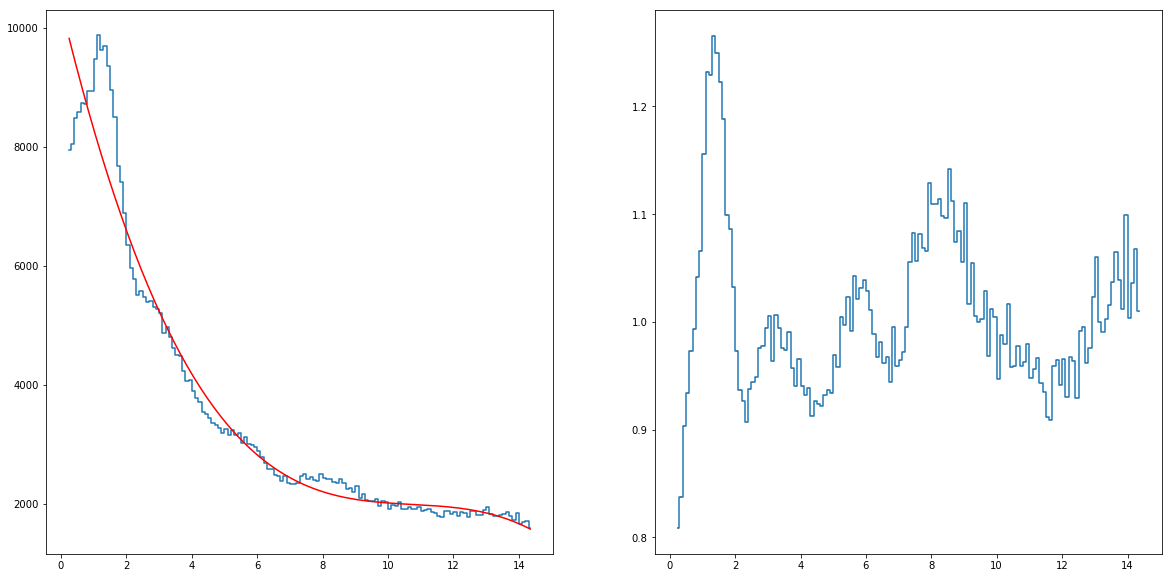

998000
no of xi bins = 141


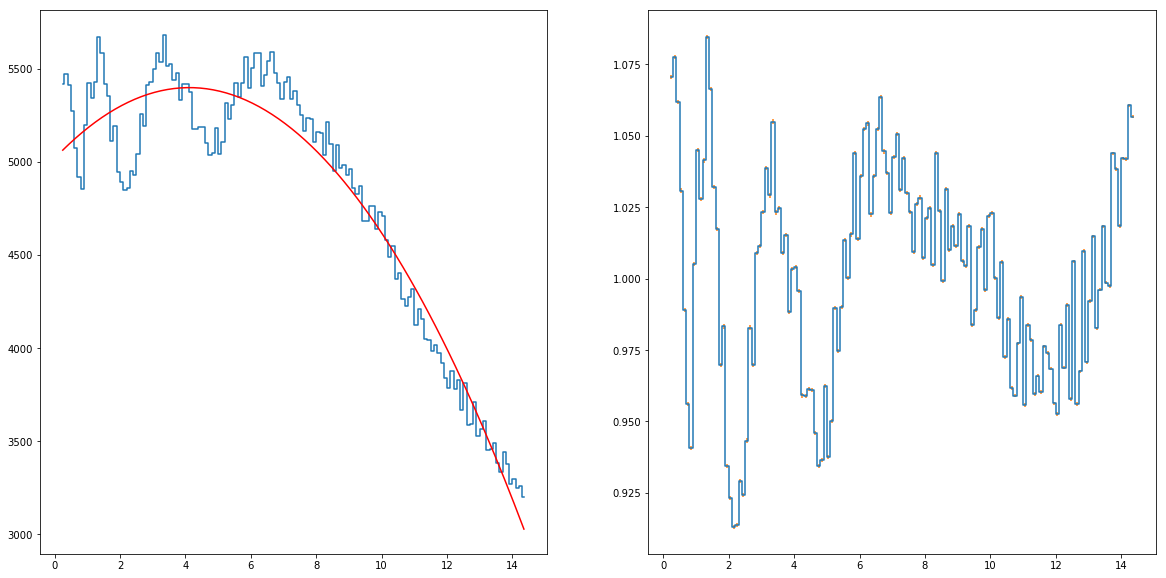

In [27]:
midxi,nden_poly,err=compute_ndenxi_polyfit(xi_t,minxi=0.25,maxxi=14.35,bw=0.1)
midxi1,nden_poly1,err1=compute_ndenxi_polyfit(xi_t1,minxi=0.25,maxxi=14.35,bw=0.1)

In [28]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fo=open(outdir + 'Pal5_density_samples_polyfit_trailing_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_poly)):
    fo.write(str(midxi[j]) + "   " + str(nden_poly[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

fo1=open(outdir + 'Pal5_density_samples_polyfit_trailing_SCFbarMbar10_10_barphi27_patspeed60.dat','w')
fo1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_poly1)):
    fo1.write(str(midxi1[jj]) + "   " + str(nden_poly1[jj]) + "   " + str(err1[jj]) + "\n")
    
fo1.close()

In [33]:
def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0]
    tdata=data[:,1]
    data_err=data[:,2]
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err




def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.01,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':



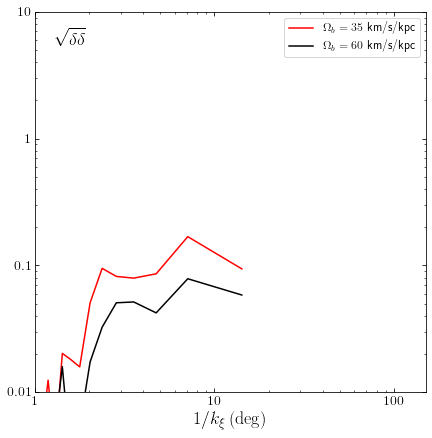

In [34]:
filename=outdir + 'Pal5_density_samples_polyfit_trailing_SCFbarMbar10_10_barphi27_patspeed35.dat'
filename1=outdir + 'Pal5_density_samples_polyfit_trailing_SCFbarMbar10_10_barphi27_patspeed60.dat'

px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px,py,color='r',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc')
loglog(px,pyerr,lw=2.,color='r',zorder=1,ls='--')
loglog(px1,py1,color='k',zorder=1,label=r'$\Omega_{b} = 60$\ km/s/kpc')
loglog(px1,pyerr1,lw=2.,color='k',zorder=1,ls='--')
set_ranges_and_labels_dens()
legend(loc='upper right')



# include stars from both arms

In [ ]:
min_eta_t=min(eta_t)
max_eta_t=max(eta_t)

xi_l_select=[]
eta_l_select=[]

for jj in range(len(eta_l)):
    if min_eta_t <= eta_l[jj] <= max_eta_t :
        xi_l_select.append(xi_l[jj])
        eta_l_select.append(eta_l[jj])

print (len(xi_l), len(xi_l_select))

plt.figure()
plt.scatter(xi_l_select,eta_l_select)
plt.show()

min_eta_t1=min(eta_t1)
max_eta_t1=max(eta_t1)

xi_l_select1=[]
eta_l_select1=[]

for jj in range(len(eta_l1)):
    if min_eta_t1 <= eta_l1[jj] <= max_eta_t1 :
        xi_l_select1.append(xi_l1[jj])
        eta_l_select1.append(eta_l1[jj])

print (len(xi_l1), len(xi_l_select1))

plt.figure()
plt.scatter(xi_l_select1,eta_l_select1)
plt.show()

In [ ]:
xi_all = np.concatenate((xi_t,xi_l_select))

midxi_all,nden_all,err_all = compute_ndenxi(xi_all,minxi=0.25,maxxi=14.35,bw=0.1)

xi_all1 = np.concatenate((xi_t1,xi_l_select1))

midxi_all1,nden_all1,err_all1 = compute_ndenxi(xi_all1,minxi=0.25,maxxi=14.35,bw=0.1)



#35 km/s/kpc
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)

plt.plot(midxi_all,nden_all,ls='steps-mid')
plt.errorbar(midxi_all,nden_all,err_all,marker='None',ls='None')
plt.title(r'$\Omega_{b} = 35$ km/s/kpc')
plt.xlim(0.,14.5)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel('dens contrast')


#60km/s/kpc
plt.subplot(1,2,2)
plt.plot(midxi_all1,nden_all1,ls='steps-mid')
plt.errorbar(midxi_all1,nden_all1,err_all1,marker='None',ls='None')
plt.title(r'$\Omega_{b} = 60$ km/s/kpc')
plt.xlim(0.,14.5)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel('dens contrast')
plt.show()

In [ ]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'
fo_all=open(outdir + 'Pal5_density_samples_both_arms_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all)):
    fo_all.write(str(midxi_all[j]) + "   " + str(nden_all[j]) + "   " + str(err_all[j]) + "\n")
    
fo_all.close()

fo_all1=open(outdir + 'Pal5_density_samples_both_arms_SCFbarMbar10_10_barphi27_patspeed60.dat','w')
fo_all1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all1)):
    fo_all1.write(str(midxi_all1[jj]) + "   " + str(nden_all1[jj]) + "   " + str(err_all1[jj]) + "\n")
    
fo_all1.close()

In [ ]:
filename_all=outdir + 'Pal5_density_samples_both_arms_SCFbarMbar10_10_barphi27_patspeed35.dat'
filename_all1=outdir + 'Pal5_density_samples_both_arms_SCFbarMbar10_10_barphi27_patspeed60.dat'

px_all,py_all,pyerr_all=compute_Pk(filename_all, scaling = 'spectrum')
px_all1,py_all1,pyerr_all1=compute_Pk(filename_all1, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px_all,py_all,color='r',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc')
loglog(px_all,pyerr_all,lw=2.,color='r',zorder=1,ls='--')
loglog(px_all1,py_all1,color='k',zorder=1,label=r'$\Omega_{b} = 60$\ km/s/kpc')
loglog(px_all1,pyerr_all1,lw=2.,color='k',zorder=1,ls='--')
set_ranges_and_labels_dens()
legend(loc='upper right')
